<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood_Hessians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [4]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     / 10.6MB 1.1MB/s


In [0]:
import corner

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0513 03:49:09.181629 140393168512896 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [40]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth


### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])



##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)



# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])



def unnormalized_log_prob(x):
  xx                   = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass'], lambda:x)
  x_                   = tf.reshape(generator(xx),[3,data_dim,n_channels])

  likeli_x             = tfd.Independent(tfd.MultivariateNormalDiag(loc=x_,scale_diag=sigma_corr))
  
  likeli_log_prob_x    = likeli_x.log_prob(x_corr)

  prior_x              = prior.log_prob(x)

  posterior            = prior_x+likeli_log_prob_x
  
  return posterior

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((3,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)
ini_chain = tf.cast(np.asarray(np.ones((hidden_size,3),dtype=np.float32)*[0.0,0.5,1]).T, tf.float32)
# Initialize the HMC transition kernel.
num_results = int(2e4)
num_burnin_steps = int(1e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)


# # # construct a GMM approximation from different minima
num_comp = 5
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
  sigma_gmm   = tf.constant(ini_val2)
  sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
update_c      = sigma_gmmt.assign(sigma_est)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  =tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

# saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:55.839668 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:55.893064 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:55.977895 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:56.669562 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:57.104467 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:57.180297 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:58.415218 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:58.518617 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:59.001985 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:46:59.116671 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:02.050394 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:02.165891 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:03.277979 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:03.409880 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:03.865595 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:04.006449 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:04.359858 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:04.508289 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:04.603503 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:07.806008 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:07.985984 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:10.812982 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:11.011104 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:12.331968 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:12.611618 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:14.403615 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 04:47:14.647940 140393168512896 saver.py:1483] Saver not created because there are no variables in the graph to restore


array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


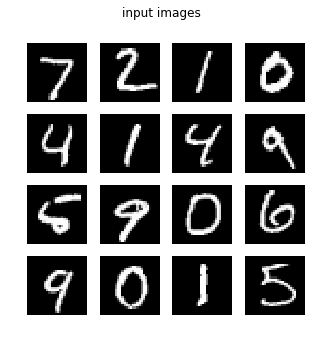

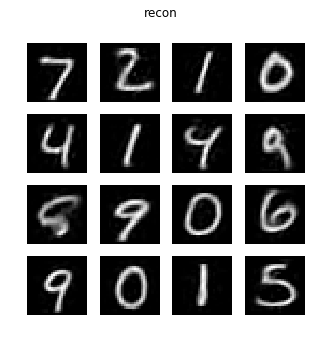

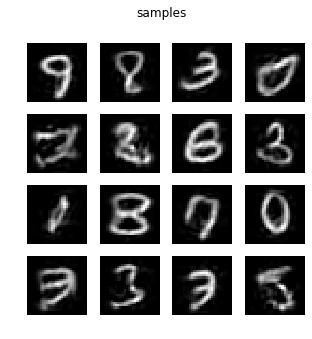

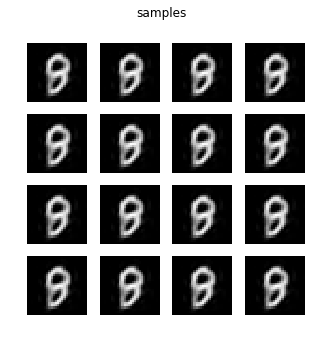

In [19]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
nvp_loss = []
ii     = 0
nepoch = 0
learning_rate = 1e-3

In [0]:
#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    np.random.shuffle(x_train)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>10:
    learning_rate=1e-5
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  nvp_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

NameError: ignored

In [0]:
plt.figure()
plot(nvp_loss[::],label='nvp loss')
legend()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [20]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0512 18:48:12.441389 140310440388480 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


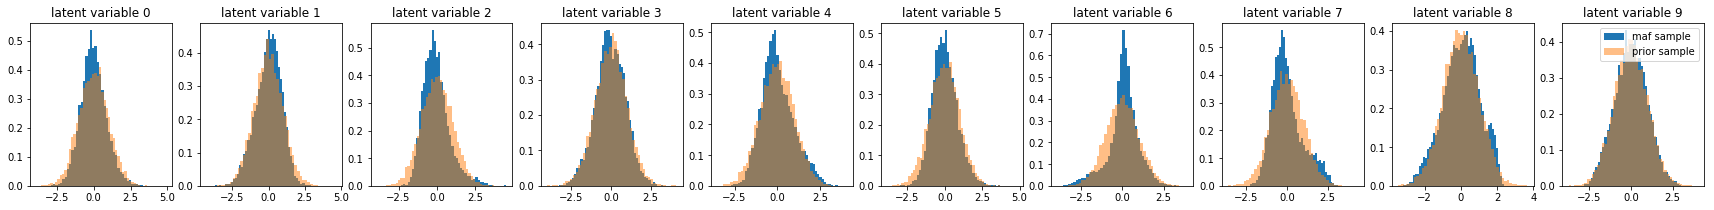

In [21]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

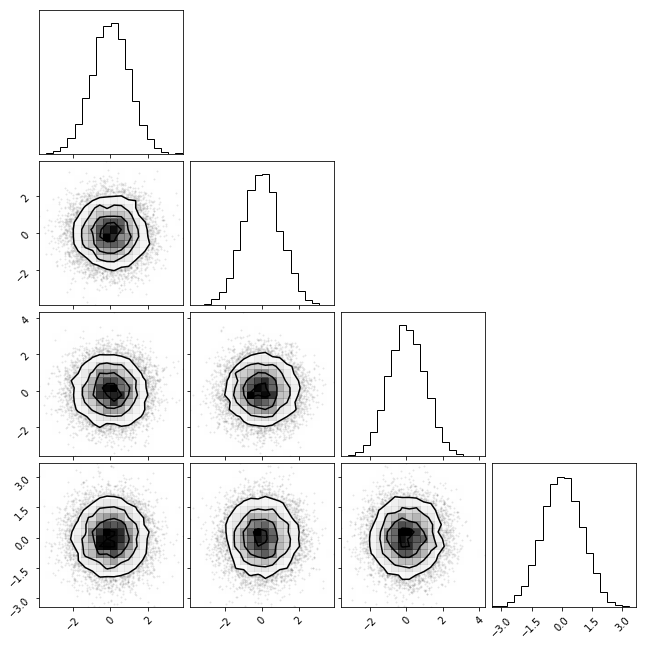

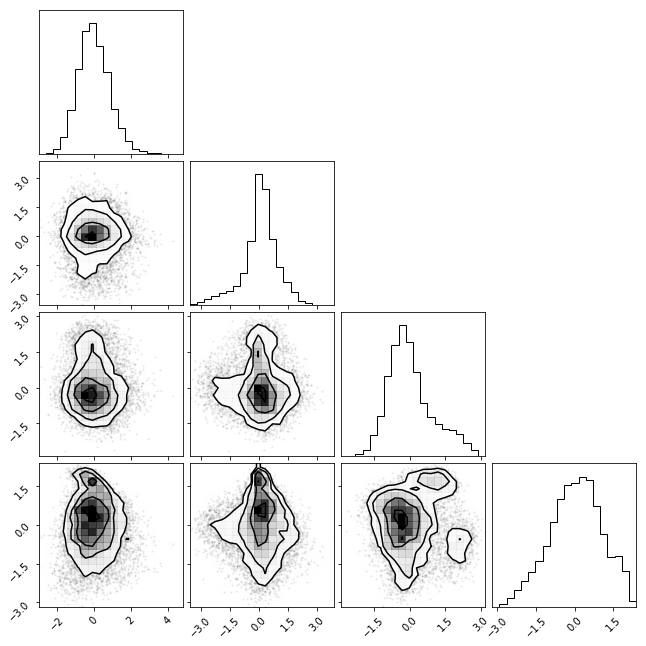

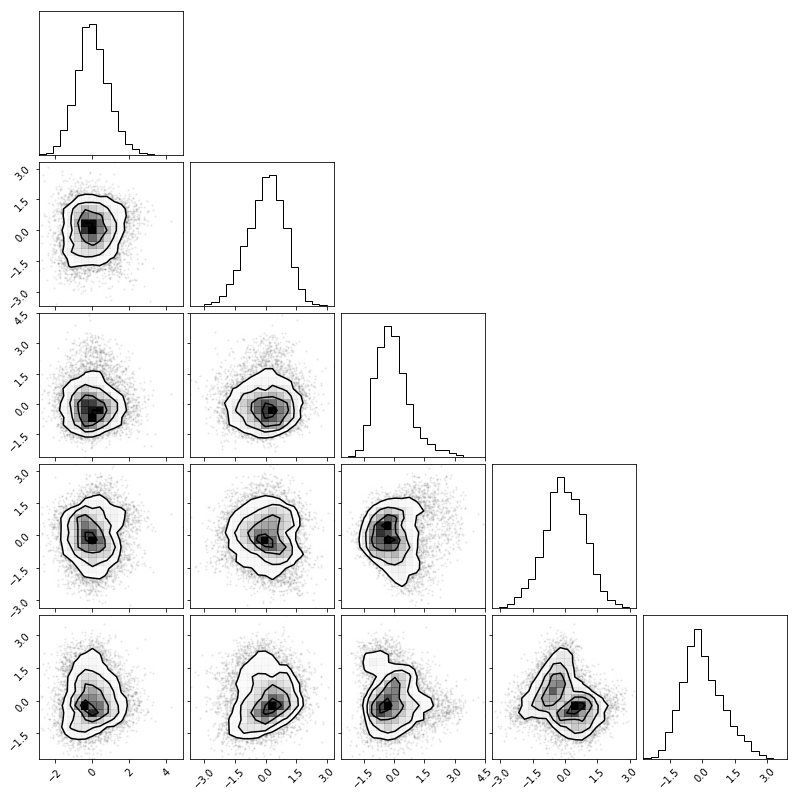

In [22]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

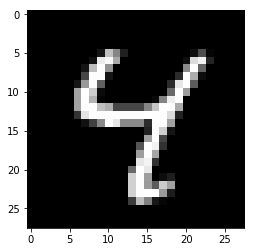

In [43]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 0#12
maxx = 0#20
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [26]:
lrate=1e-1
for ii in range(8000):
  if ii >4000:
    lrate=1e-4
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

1807.7767
2036.6693
1717.7948
1723.9429
1722.9568
1717.4481
1722.8846
1717.9202
1716.8809
1716.0249
1722.3477
1714.8907
1721.6625
1710.1282
1720.0531
1713.3162
1711.5708
1715.7245
1716.4938
1716.3175
1724.2367
1713.402
1711.7605
1736.2471
1712.9266
1717.6655
1714.7983
1719.2858
1712.7015
1719.3293
1714.1799
1720.5282
1734.3026
1760.4625
1718.301
1713.1045
1785.863
1720.2665
1716.7499
1717.9768
1734.333
1736.9202
1727.2075
1729.4257
1733.9423
1729.3512
1725.578
1721.758
1727.5903
1721.3142
1724.063
1723.4625
1730.3966
1728.9142
1732.1467
1722.7676
1723.2622
1733.9031
1731.0925
1721.6398
1719.7422
1723.3071
1724.4923
1723.7566
1723.55
1732.5635
1722.0319
1721.742
1721.5037
1721.9893
1725.967
1721.4252
1721.043
1721.4556
1726.4054
1718.5406
1728.1393
1723.1371
1723.9312
1724.6113


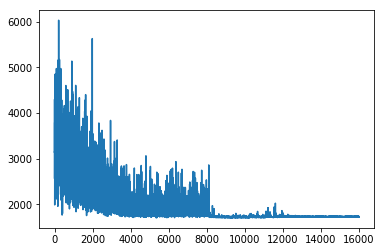

In [27]:
plt.plot(posterior_loss)

In [28]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
print(samples.shape)

(1, 64, 784, 1)


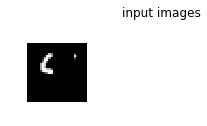

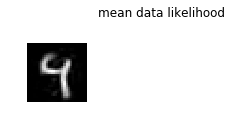

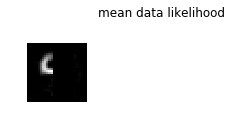

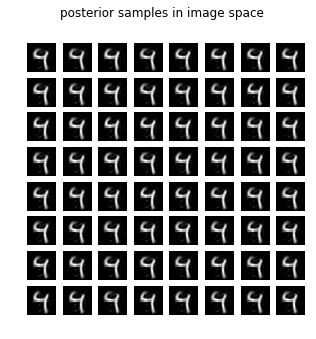

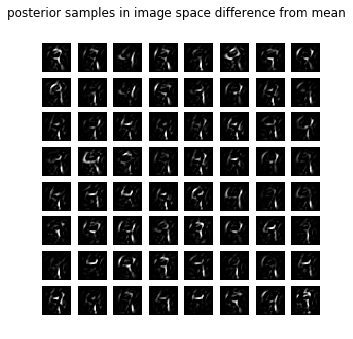

In [29]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()

B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [34]:
lrate=1e-4
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

1757.9868
1732.0378
1756.0874
1744.6215
1737.1855
1749.8425
1793.3452
1789.1534
1767.9802
1728.9739
1754.5065
1734.46
1756.6299
1739.8738
1737.8163
1736.4469
1732.5654
1761.4568
1737.1616
1776.563


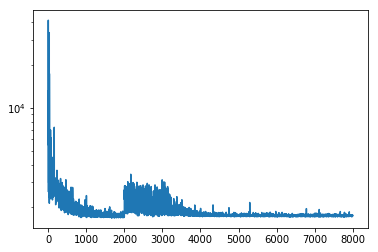

In [35]:
plt.plot(posterior_loss)
yscale('log')

In [36]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
print(samples.shape)

(1, 64, 784, 1)


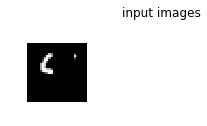

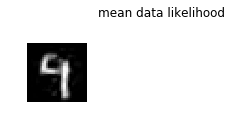

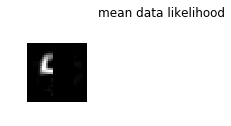

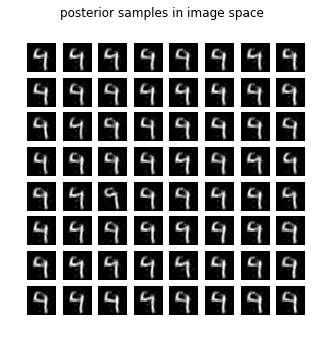

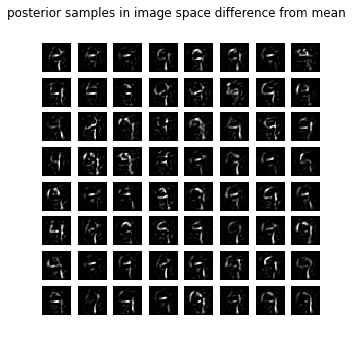

In [37]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.show()

**find minima with nvp**

0
2318.1853
1199.8655
1199.4629
1203.2385
1204.0645
1200.6315
1200.9143
1200.0079
1217.6506
1214.7104
switching to lr 0.01
1201.192
1198.3628
1198.3833
1198.4652
1198.4628
switching to lr 0.001
1198.6686
1198.3593
1
1943.167
1909.2429
1896.2976
1896.3573
1898.3611
1909.6575
1898.4761
1902.1934
1899.3052
1897.9382
switching to lr 0.01
1896.9675
1895.7212
1895.7295
1895.8013
1896.0151
switching to lr 0.001
1895.791
1895.6847
2
3481.7546
2185.3108
2263.526
2219.91
1826.501
1602.2642
1488.8094
1489.1011
1495.3491
1504.3337
switching to lr 0.01
1490.5975
1488.5812
1488.601
1488.6823
1488.668
switching to lr 0.001
1488.8417
1488.5471
3
3084.0837
1542.4988
1541.9307
1542.1934
1542.2705
1542.0613
1541.743
1542.8099
1542.1206
1542.1451
switching to lr 0.01
1541.9691
1541.662
1541.6517
1541.6467
1541.6293
switching to lr 0.001
1541.8204
1541.6036
4
2896.1958
1588.2965
1584.4368
1580.1799
1572.6091
1578.9106
1572.2572
1573.9497
1574.551
1293.5297
switching to lr 0.01
1253.3607
1252.6545
1252.5511

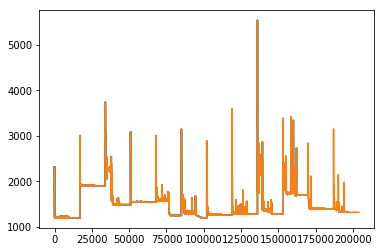

In [83]:
posterior_corr_loss=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_corr_loss,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]

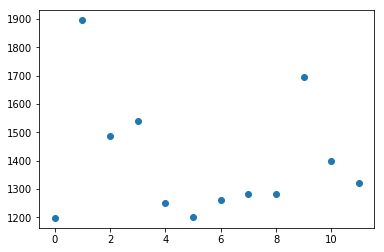

In [84]:
plt.figure()
plt.plot(np.arange(12),l_minima,ls='',marker='o')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima= np.asarray(map_minima)
l_minima= np.asarray(l_minima)

In [86]:
print(map_minima[0])

[[[ 2.6803303   0.52356946 -1.3828627   0.76382756  0.7004655
    0.9963898  -0.18421985 -3.4723957   1.1985819  -0.34135965]]]


**Sample posterior of (un)corrupted data**

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1), nvp_prior:True})

In [45]:
print(samples_.shape)

(20000, 3, 10)


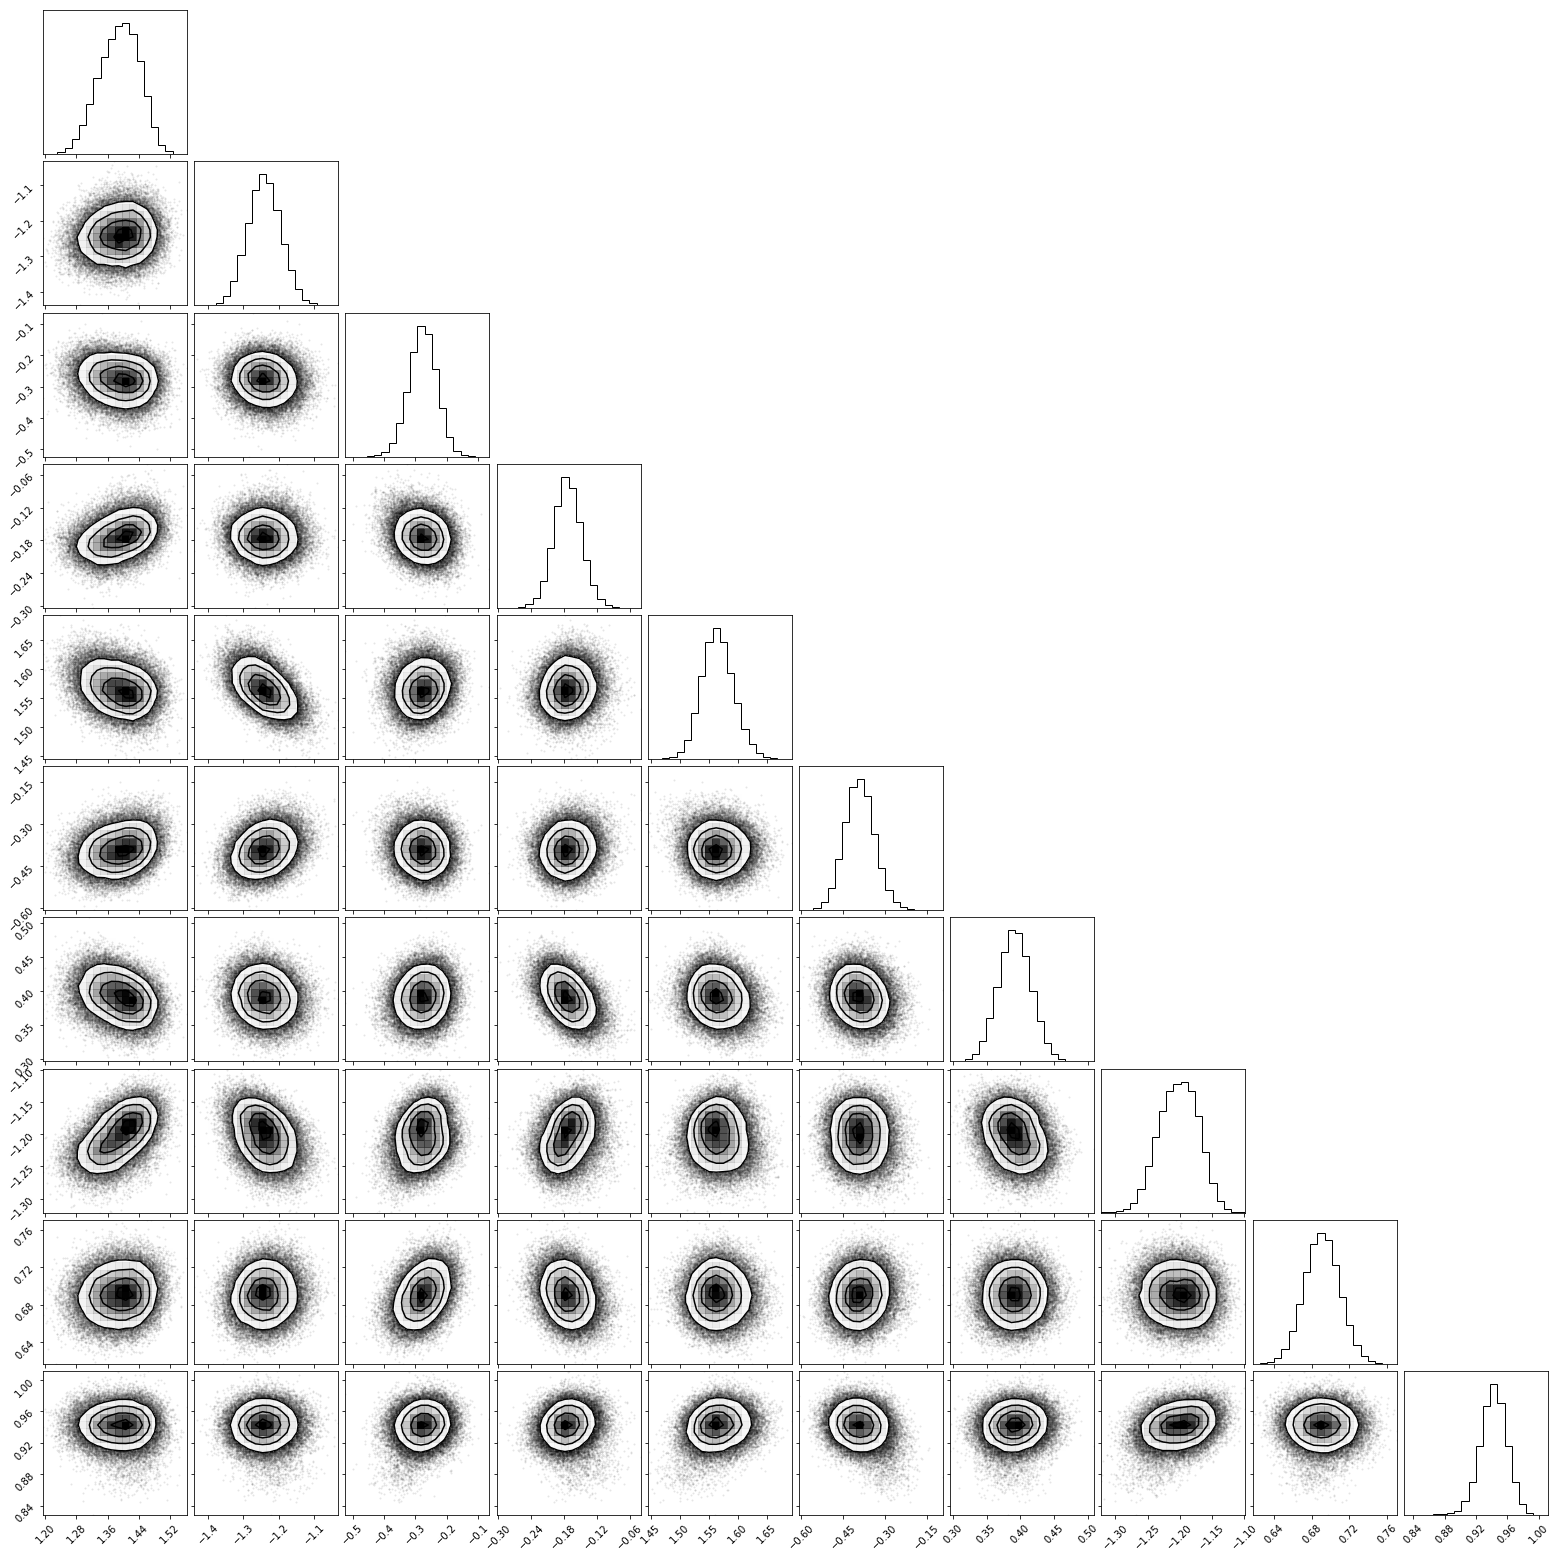

In [47]:
order = np.argsort(l_minima_old)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
# axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
# for yi in range(hidden_size):
#     for xi in range(yi):
#         ax = axes[yi, xi]
#         ax.scatter(map_minima_old[:,0,0,xi], map_minima_old[:,0,0,yi])
#         for i, txt in enumerate(l_minima_old):
#           ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]))


In [44]:
# 

AttributeError: ignored

mean:0.1693  stddev:0.9419  acceptance:0.6615


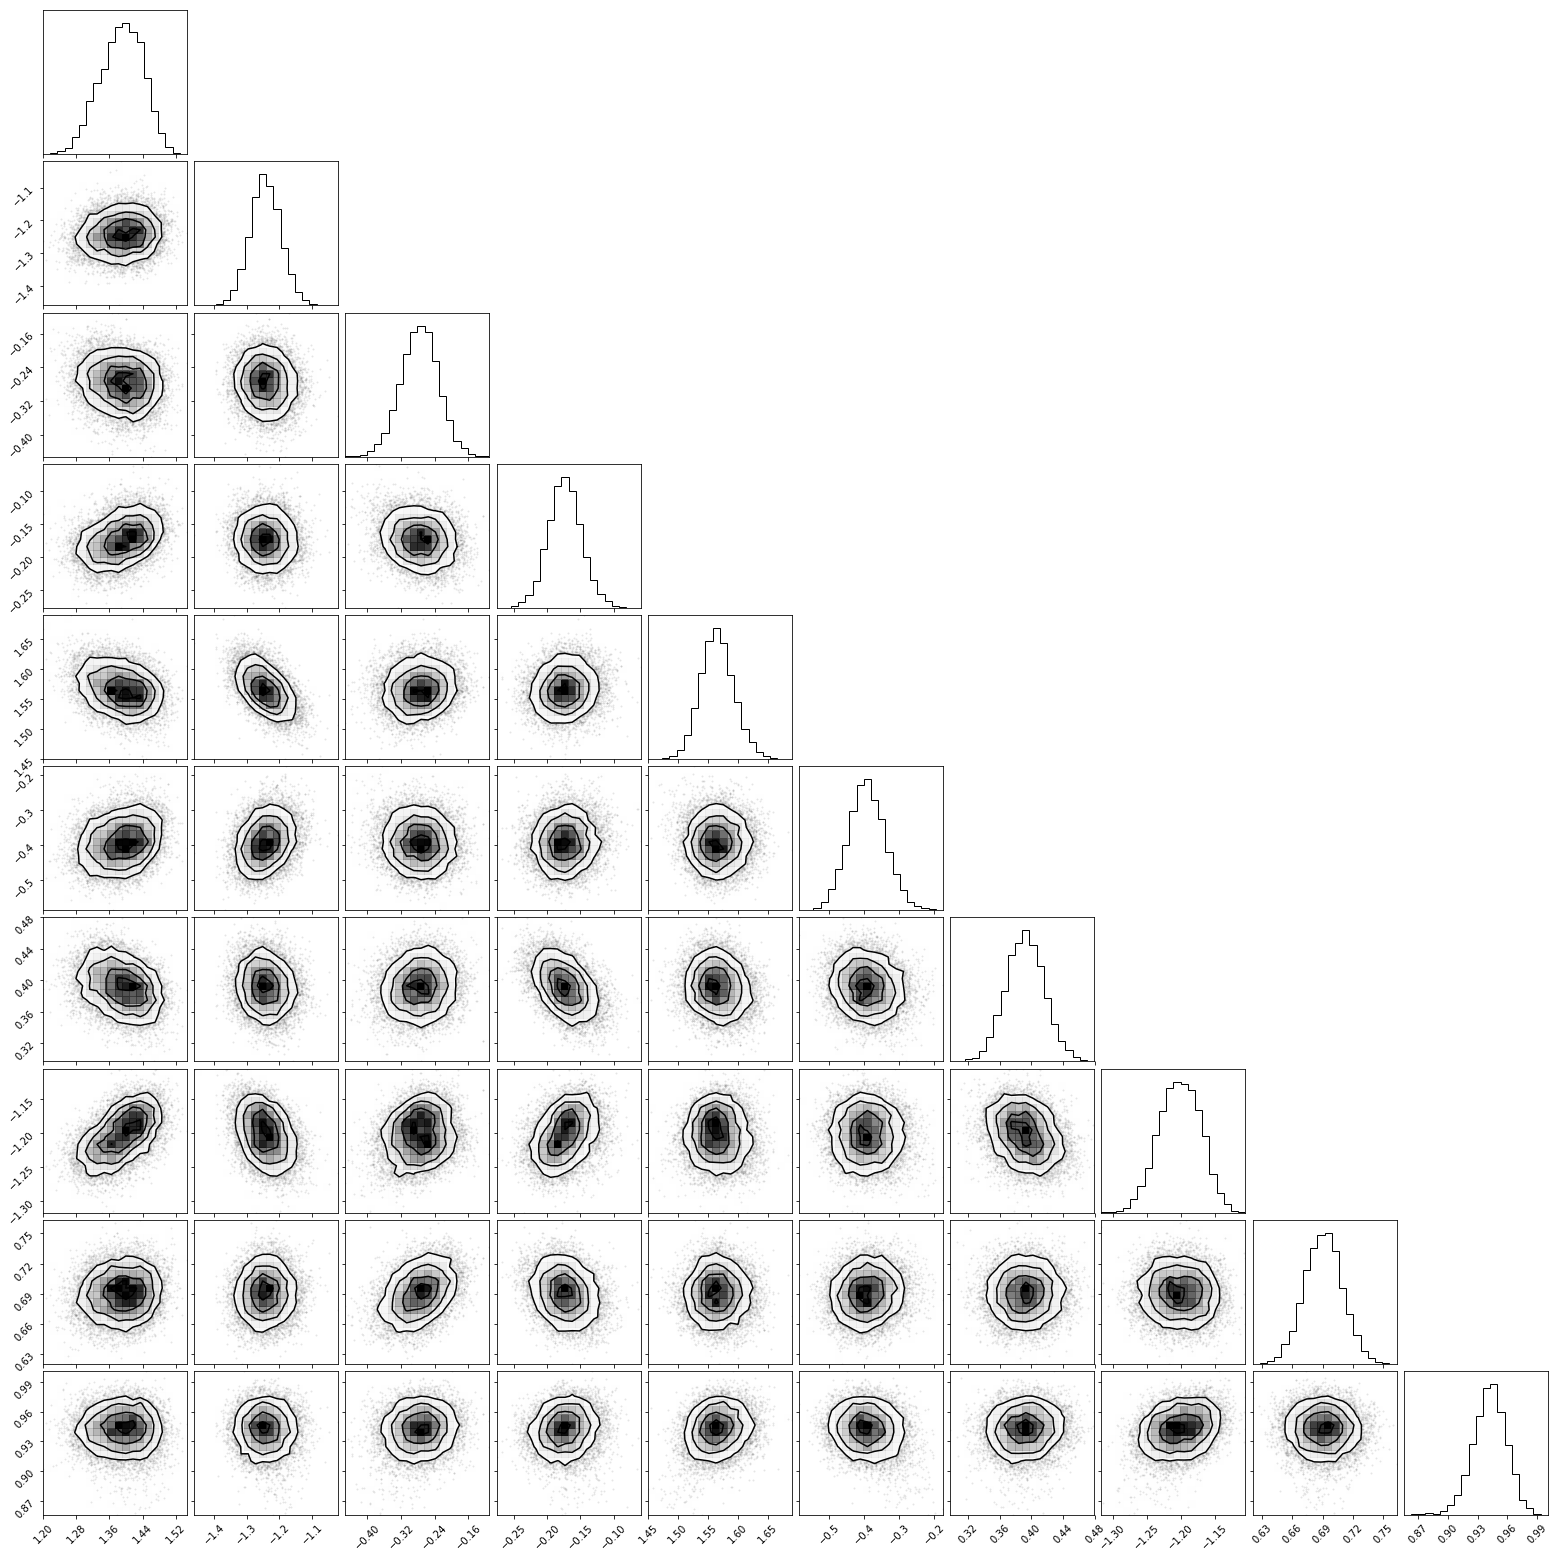

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

**get covariances around minima**

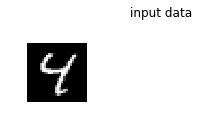

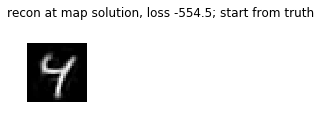

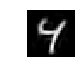

eigenvalues before and after inverse, approx hessian
[array([[9.9777007e-01, 9.9873662e-01, 9.9955773e-01, 9.9994117e-01,
        9.9997073e-01, 1.0000000e+00, 1.0001444e+00, 1.0011126e+00,
        1.0138040e+00, 2.7798334e+05]], dtype=float32), array([[3.59733835e-06, 9.98470634e-01, 9.99418609e-01, 9.99591387e-01,
        9.99904766e-01, 9.99999960e-01, 1.00014762e+00, 1.00030595e+00,
        1.00205291e+00, 1.00632821e+00]])]


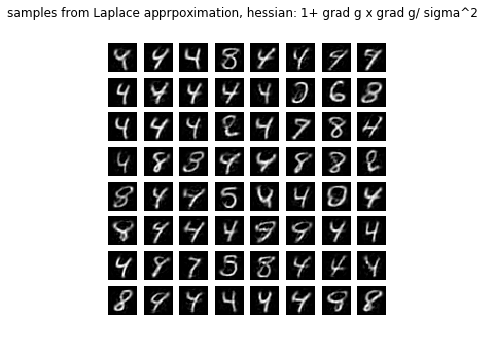

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9777007e-01, 9.9873662e-01, 9.9955773e-01, 9.9994117e-01,
        9.9997073e-01, 1.0000000e+00, 1.0001444e+00, 1.0011126e+00,
        1.0138040e+00, 2.7798334e+05]], dtype=float32), array([[3.59733835e-06, 9.98470634e-01, 9.99418609e-01, 9.99591387e-01,
        9.99904766e-01, 9.99999960e-01, 1.00014762e+00, 1.00030595e+00,
        1.00205291e+00, 1.00632821e+00]])]


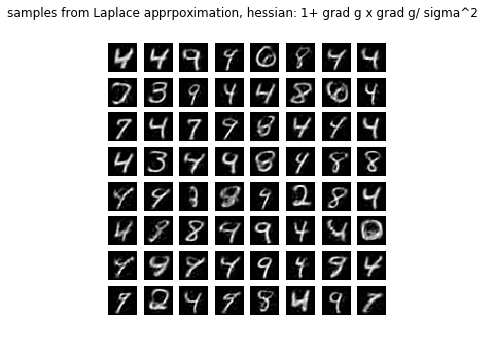

covariances
(1, 10, 10)


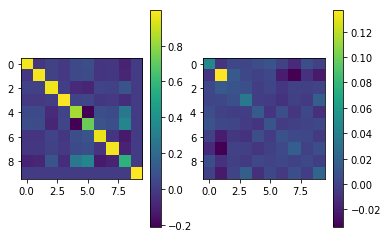

hessians
(1, 10, 10)


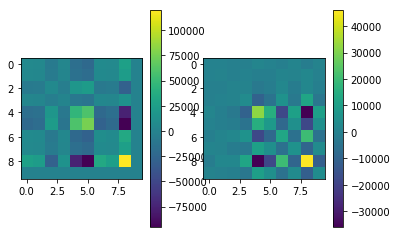

eigenvalues before and after inverse, full hessian
[array([[6.44479036e+00, 1.76998425e+01, 1.85601311e+01, 3.91172180e+01,
        1.05423676e+02, 5.72566589e+02, 8.30782410e+02, 2.81913843e+03,
        6.21066602e+03, 1.02951391e+05]], dtype=float32), array([[9.71332120e-06, 1.61013450e-04, 3.54718198e-04, 1.20368956e-03,
        1.74652346e-03, 9.48558063e-03, 2.55638926e-02, 5.38793506e-02,
        5.65015620e-02, 1.55166450e-01]])]
10


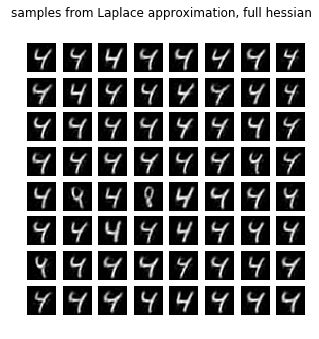

1


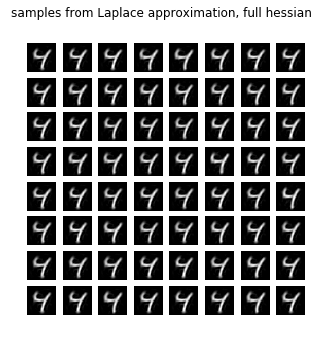

1e-32


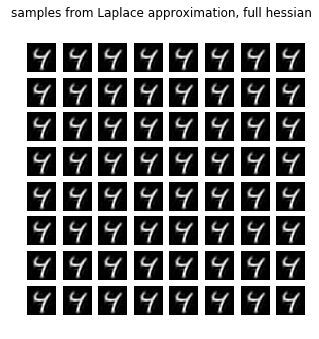

diagonal approx


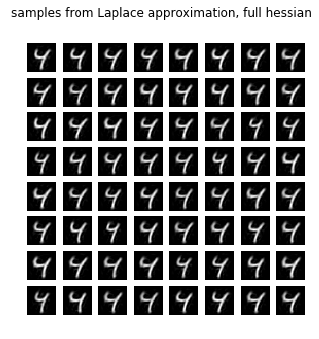

2278.218
2423.8955
2410.1802
2410.8203
2430.8677
2435.7126
5893.7905
2436.3945
2418.1614
2426.3538
2435.6223
2444.795
2435.5813
2433.8877
2441.0198
2457.7065
2438.9844
2442.1433
2441.978
2440.0322


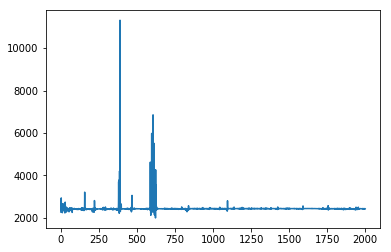

variance of VI [[0.01616848 0.04449824 0.00010066 0.00079332 0.00015424 0.008821
  0.00010882 0.00010441 0.00010009 0.00400446]]


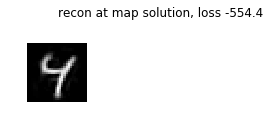

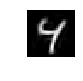

eigenvalues before and after inverse, approx hessian
[array([[9.9729574e-01, 9.9891806e-01, 9.9955666e-01, 9.9968058e-01,
        9.9997723e-01, 1.0000476e+00, 1.0002271e+00, 1.0015213e+00,
        1.0072515e+00, 2.7268500e+05]], dtype=float32), array([[3.66723486e-06, 9.96052473e-01, 9.99357824e-01, 9.99525314e-01,
        9.99844819e-01, 9.99952089e-01, 1.00007640e+00, 1.00019051e+00,
        1.00053138e+00, 1.00294261e+00]])]


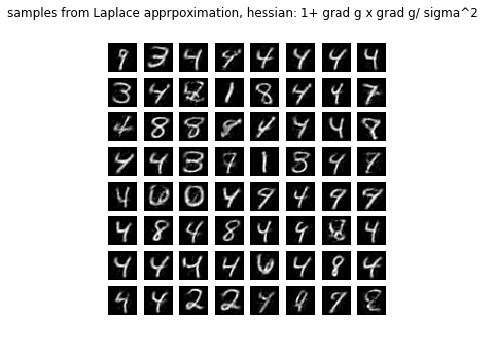

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9729574e-01, 9.9891806e-01, 9.9955666e-01, 9.9968058e-01,
        9.9997723e-01, 1.0000476e+00, 1.0002271e+00, 1.0015213e+00,
        1.0072515e+00, 2.7268500e+05]], dtype=float32), array([[3.66723486e-06, 9.96052473e-01, 9.99357824e-01, 9.99525314e-01,
        9.99844819e-01, 9.99952089e-01, 1.00007640e+00, 1.00019051e+00,
        1.00053138e+00, 1.00294261e+00]])]


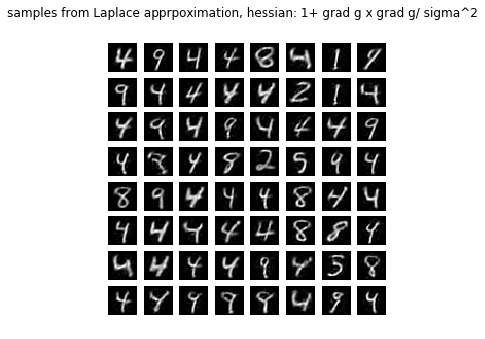

covariances
(1, 10, 10)


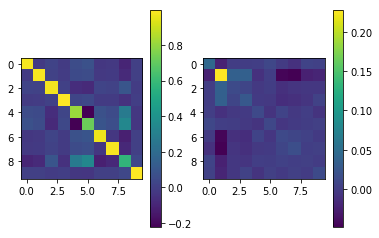

hessians
(1, 10, 10)


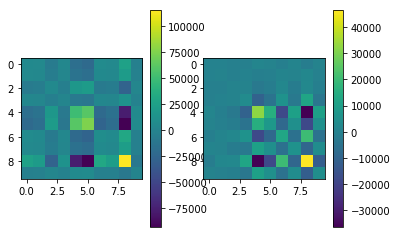

eigenvalues before and after inverse, full hessian
[array([[3.7613430e+00, 1.9096727e+01, 3.2284142e+01, 4.4697334e+01,
        1.0704494e+02, 5.5545251e+02, 9.1569006e+02, 2.9982295e+03,
        6.1759536e+03, 1.0423590e+05]], dtype=float32), array([[9.59362066e-06, 1.61918263e-04, 3.33530046e-04, 1.09207278e-03,
        1.80034013e-03, 9.34185891e-03, 2.23722546e-02, 3.09711115e-02,
        5.23650462e-02, 2.65864411e-01]])]
10


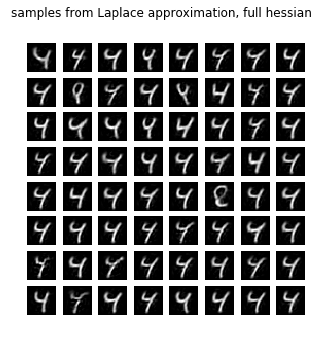

1


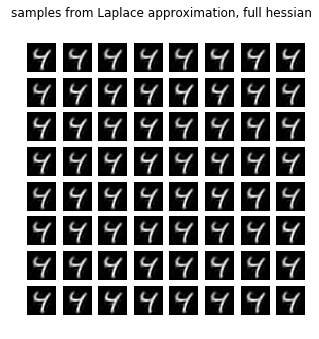

1e-32


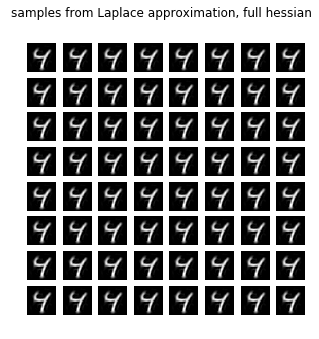

diagonal approx


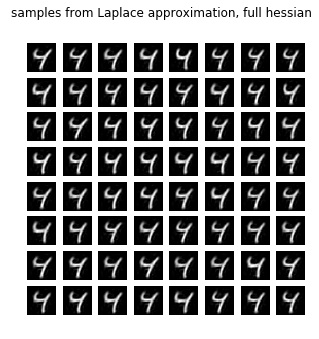

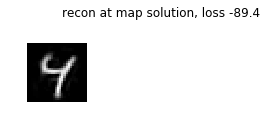

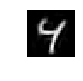

eigenvalues before and after inverse, approx hessian
[array([[9.8884958e-01, 9.9951839e-01, 9.9961627e-01, 9.9989480e-01,
        1.0001360e+00, 1.0003946e+00, 1.0005190e+00, 1.0009059e+00,
        1.0018771e+00, 2.9108100e+05]], dtype=float32), array([[3.43546909e-06, 9.95305821e-01, 9.99427660e-01, 9.99693184e-01,
        9.99912085e-01, 9.99991837e-01, 1.00008747e+00, 1.00013000e+00,
        1.00033255e+00, 1.00411743e+00]])]


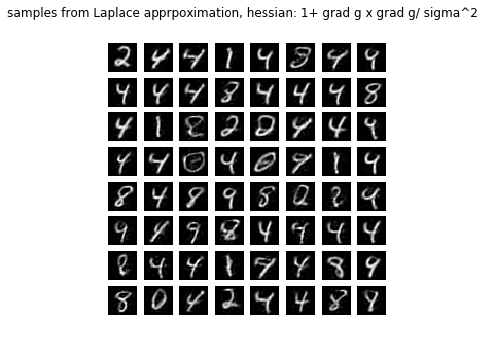

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.8884958e-01, 9.9951839e-01, 9.9961627e-01, 9.9989480e-01,
        1.0001360e+00, 1.0003946e+00, 1.0005190e+00, 1.0009059e+00,
        1.0018771e+00, 2.9108100e+05]], dtype=float32), array([[3.43546909e-06, 9.95305821e-01, 9.99427660e-01, 9.99693184e-01,
        9.99912085e-01, 9.99991837e-01, 1.00008747e+00, 1.00013000e+00,
        1.00033255e+00, 1.00411743e+00]])]


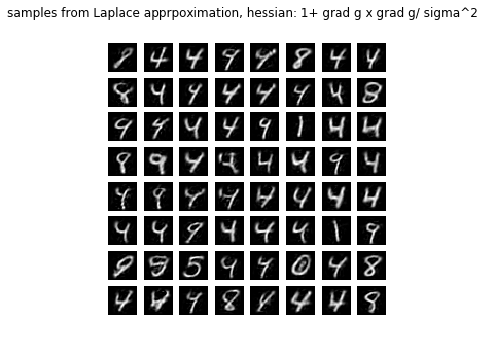

covariances
(1, 10, 10)


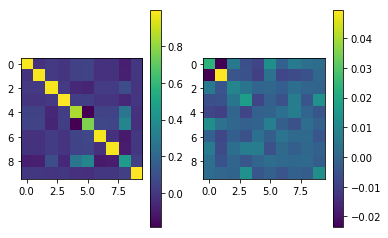

hessians
(1, 10, 10)


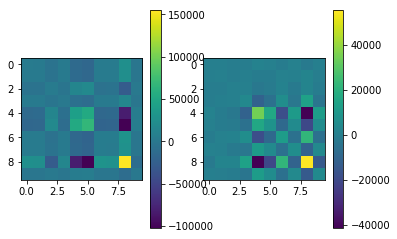

eigenvalues before and after inverse, full hessian
[array([[-4.5845417e+01,  1.4793127e+01,  2.8948008e+01,  3.5316547e+01,
         9.7997192e+01,  4.2988376e+02,  9.3819550e+02,  3.0588782e+03,
         6.6023105e+03,  1.1562748e+05]], dtype=float32), array([[-2.18110802e-02,  8.64846141e-06,  1.51462296e-04,
         3.26917251e-04,  1.06587782e-03,  2.32621597e-03,
         1.02043956e-02,  2.83147464e-02,  3.45470253e-02,
         6.75998760e-02]])]
10
full hessian fails


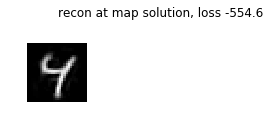

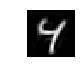

eigenvalues before and after inverse, approx hessian
[array([[9.9153656e-01, 9.9934787e-01, 9.9989635e-01, 9.9997848e-01,
        1.0000063e+00, 1.0000826e+00, 1.0003662e+00, 1.0004261e+00,
        1.0011920e+00, 2.1085555e+05]], dtype=float32), array([[4.74258206e-06, 9.98509957e-01, 9.99604392e-01, 9.99680273e-01,
        9.99773508e-01, 1.00000990e+00, 1.00001583e+00, 1.00013938e+00,
        1.00028710e+00, 1.00086042e+00]])]


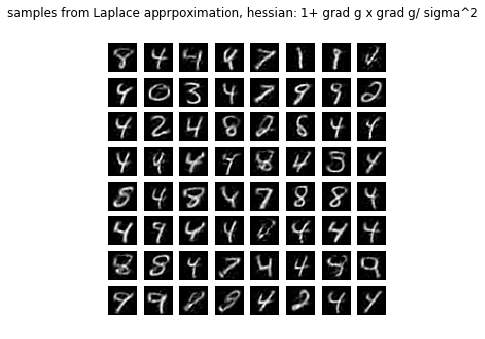

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9153656e-01, 9.9934787e-01, 9.9989635e-01, 9.9997848e-01,
        1.0000063e+00, 1.0000826e+00, 1.0003662e+00, 1.0004261e+00,
        1.0011920e+00, 2.1085555e+05]], dtype=float32), array([[4.74258206e-06, 9.98509957e-01, 9.99604392e-01, 9.99680273e-01,
        9.99773508e-01, 1.00000990e+00, 1.00001583e+00, 1.00013938e+00,
        1.00028710e+00, 1.00086042e+00]])]


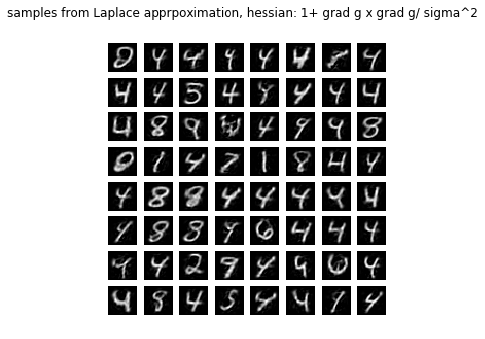

covariances
(1, 10, 10)


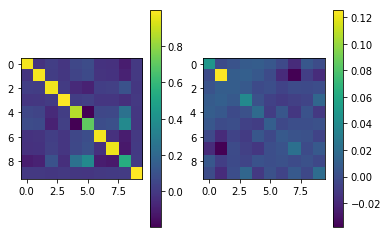

hessians
(1, 10, 10)


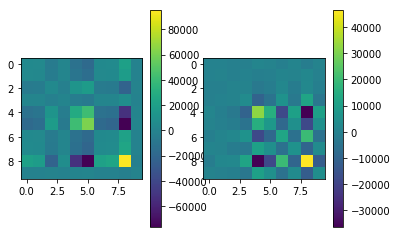

eigenvalues before and after inverse, full hessian
[array([[6.7787976e+00, 1.6002310e+01, 1.9371960e+01, 3.4683811e+01,
        1.0196359e+02, 5.3757257e+02, 8.3181079e+02, 2.8250974e+03,
        6.0682227e+03, 1.0368430e+05]], dtype=float32), array([[9.64466320e-06, 1.64792831e-04, 3.53970034e-04, 1.20220011e-03,
        1.86021935e-03, 9.80745182e-03, 2.88307243e-02, 5.16201450e-02,
        6.24925732e-02, 1.47514219e-01]])]
10


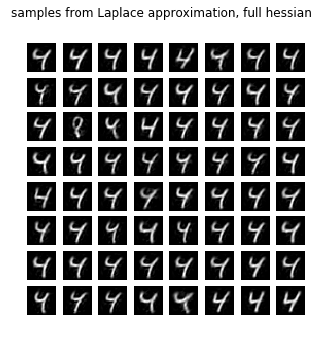

1
full hessian fails


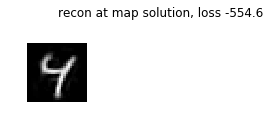

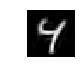

eigenvalues before and after inverse, approx hessian
[array([[9.9248832e-01, 9.9955171e-01, 9.9982560e-01, 9.9991047e-01,
        9.9998188e-01, 1.0000685e+00, 1.0003649e+00, 1.0014139e+00,
        1.0021964e+00, 2.0829830e+05]], dtype=float32), array([[4.80080849e-06, 9.97878008e-01, 9.98988305e-01, 9.99449860e-01,
        9.99936347e-01, 9.99995039e-01, 1.00004224e+00, 1.00015375e+00,
        1.00051523e+00, 1.00160591e+00]])]


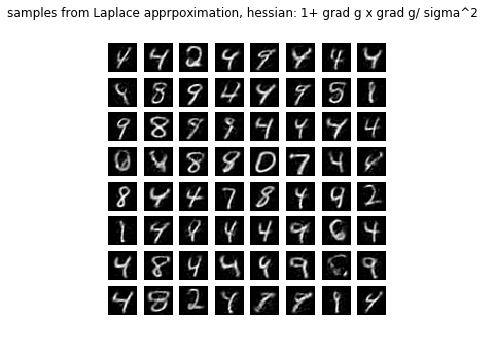

diagonal approx
eigenvalues before and after inverse, approx hessian
[array([[9.9248832e-01, 9.9955171e-01, 9.9982560e-01, 9.9991047e-01,
        9.9998188e-01, 1.0000685e+00, 1.0003649e+00, 1.0014139e+00,
        1.0021964e+00, 2.0829830e+05]], dtype=float32), array([[4.80080849e-06, 9.97878008e-01, 9.98988305e-01, 9.99449860e-01,
        9.99936347e-01, 9.99995039e-01, 1.00004224e+00, 1.00015375e+00,
        1.00051523e+00, 1.00160591e+00]])]


KeyboardInterrupt: ignored

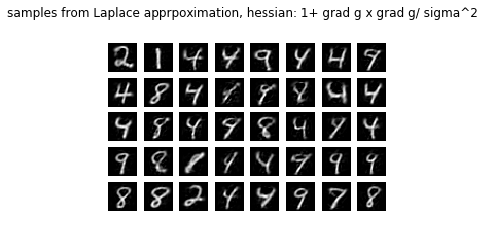

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
# order minima by loss function value
l_minima  = np.asarray(l_minima)
map_minima= np.asarray(map_minima)
order     = np.argsort(l_minima)

for ii,ini_ in enumerate(map_minima[order]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  print('diagonal approx')
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False, diag_hess:True})
  




  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [10,1,1e-32]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')

#do mean field vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new})   
    lrate=5e-1
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo_,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
    print('variance of VI', elbo_var)
    
#do full rank vae on corrupted data with mean of posterior set to MAP values
#     _ = sess.run(update5,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:True})   
#     lrate=1e-1
#     elbo_2_loss=[]
#     for ii in range(2000):
#       _, ll = sess.run([opt_op_elbo2f, elbo_f],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
#       elbo_2_loss.append(ll)
#       if ii%100==0:
#         print(ll)
#     plt.figure()
#     plt.plot(elbo_2_loss)
#     plt.show()
    
#     elbo_cov = sess.run(approx_posterior_f_elbo.covariance(),feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
#     print('covariance of VI', elbo_cov)

(12, 1, 1, 10) (4, 1, 10)
(12, 1, 1, 10) (4, 1, 10)
(12, 1, 1, 10) (4, 1, 10)
(12, 1, 1, 10) (4, 1, 10)
(12, 1, 1, 10) (4, 1, 10)


IndexError: ignored

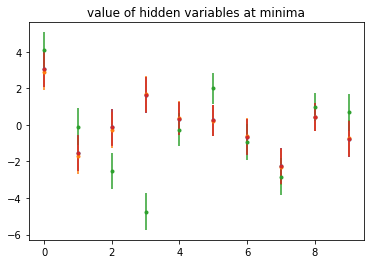

In [0]:
# check if minima are distinct
map_minima=np.asarray(map_minima)
varis = np.asarray(varis)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape, varis.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**explore posterior around minima**

3825.2636419132473 289.47916 6184.7217 3010486800.0
505.0266361508754 521.89325 4629.5386 29065608.0
98693439.84734175 804.6925 6687.29 6972012.0
1588927.2406597196 3497.4019 1796.3745 942110.0
42035190.69354801 32227.426 46618.234 11250.476
12851.805327354898 7957.9883 75989.69 20424.697
84444427.36604293 12457.855 10156.608 593.7965
91729642.95386586 5838.075 5833.6113 405.56583
99813173.26827407 46169.68 120095.23 87.749664
62360.892118081516 3807.2969 1.0051664 23.939379


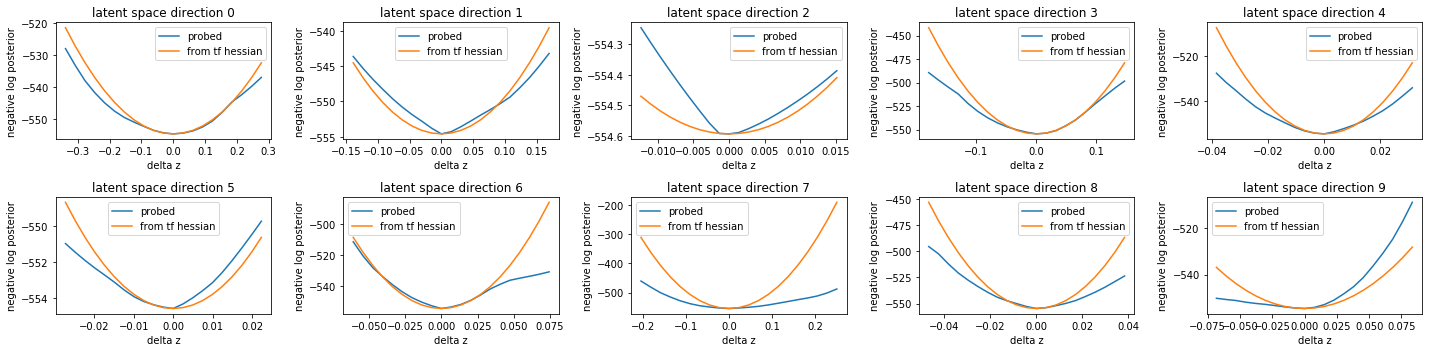

In [0]:
order     = np.argsort(l_minima)[0]

# testing Hessian
for ii,ini_ in enumerate([map_minima[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    elbo_v2 = np.linalg.inv(elbo_cov[0])[nn,nn]
    print(elbo_v,B, GN, elbo_v2)
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from tf hessian')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from mean field VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v2*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from full rank VI', color='darkblue')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


**Build Gaussian Mixture Model**

In [0]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

order   = np.argsort(l_minima)
mus     = map_minima[order]
# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  print(sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:mus[ii]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask,true_hess:True})]
  

  #diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_ = sess.run(log_det,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  w_tilde+=[np.exp(0.5*logdet_+logprob)]

mu_    = np.asarray(mu_)
sigma_ = np.asarray(sigma_)

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


_=sess.run(update_a,feed_dict={x_corr: masked_data mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: masked_data,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: masked_data,mu_est: mu_, sigma_est: sigma_, w_est:w })



**minima without nvp**

0
4244.7065
1394.3877
1394.7526
1395.8688
1394.2104
1394.2091
1394.3069
1394.1794
1394.201
1394.156
1
3062.8508
1175.9419
1176.0638
1176.0602
1175.9293
1175.9388
1175.9338
1175.9474
1175.9517
1175.9218
2
3823.828
1179.5801
1179.1759
1179.4675
1179.0948
1179.063
1179.0916
1179.078
1179.1012
1179.0555
3
3966.2188
2146.9797
2146.7664
2146.0974
2144.5415
2144.5334
2144.8044
2144.5217
2144.6772
2144.3933
4
2711.4788
1923.206
1924.2954
1923.5779
1922.6935
1922.8698
1922.9027
1922.8276
1922.7825
1922.6207
5
3483.8892
1175.9945
1175.9968
1176.0557
1176.0018
1176.0083
1176.0138
1176.0042
1176.0042
1175.989
6
3975.7546
1175.9469
1176.0131
1175.9932
1175.9258
1175.9435
1175.9646
1175.957
1175.9326
1175.9216
7
2774.436
1752.2992
1752.8484
1752.7626
1751.9335
1752.0057
1752.0653
1751.9407
1751.9397
1751.8707
8
2057.4119
1175.9878
1176.0413
1176.0365
1175.9291
1175.9265
1175.9452
1175.9408
1175.9275
1175.9215
9
5535.389
1870.2422
1868.2738
1868.4436
1867.5505
1867.429
1867.4534
1867.5057
1867.577
18

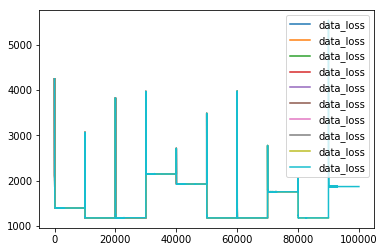

In [22]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

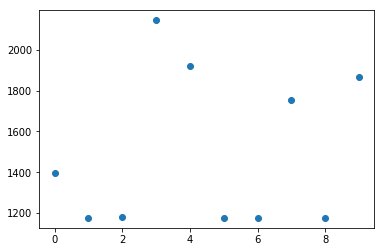

In [23]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [30]:
import pickle
try:
  l_minima_old,map_minima_old = pickle.load(open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima_old,map_minima_old],open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima_old = np.asarray(map_minima_old)
l_minima_old  = np.asarray(l_minima_old)

print(map_minima_old)

[[[[ 1.3134348  -1.4505225   1.749728   -0.01621357  0.851519
    -0.21953483  0.9846898   0.11747186  0.14619356  1.67564   ]]]


 [[[ 1.4112952  -0.06299302 -0.8182401  -0.15071896  1.8583199
    -0.22145244  0.15128574 -1.3318758   0.732929    1.6134545 ]]]


 [[[ 1.455453    0.04629096 -0.6181112  -0.27002937  1.770756
    -0.17299747  0.05943412 -1.2890917   0.7684696   1.5730884 ]]]


 [[[-1.6263283   1.1921619  -2.2144086  -0.6172965  -0.7531866
    -3.817122   -1.2250161   0.30408272  0.8309077  -0.8676701 ]]]


 [[[-0.15759993  3.2007043  -0.5950913  -2.412685   -1.1396843
     1.7715689   1.6409681   0.03772905  1.241962    0.09389108]]]


 [[[ 1.4311416  -0.02218519 -0.7938116  -0.15272759  1.8883076
    -0.22043766  0.14859445 -1.3093218   0.75688714  1.6802843 ]]]


 [[[ 1.4113084  -0.06293711 -0.8182478  -0.15074946  1.8582652
    -0.22145255  0.15124162 -1.3319583   0.73295146  1.6135219 ]]]


 [[[-1.4959058   3.8136775   0.22570148 -0.7210525   0.15733336
    -0.1384776

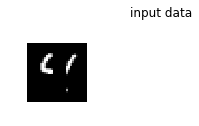

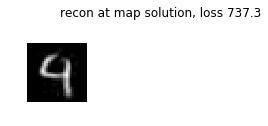

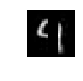

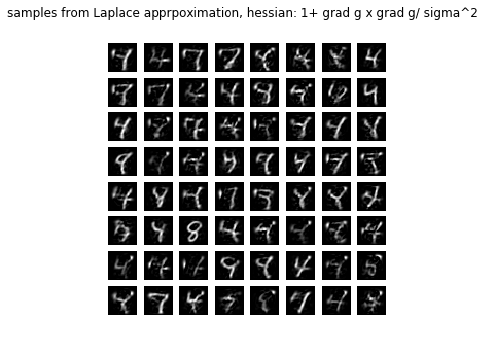

<Figure size 360x360 with 0 Axes>

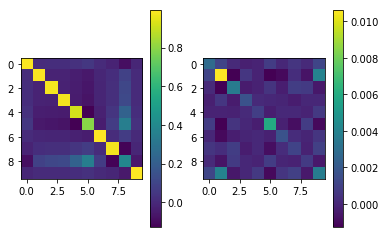

eigenvalues before and after inverse, full hessian
[array([[  74.718185,  160.16638 ,  233.34651 ,  296.10474 ,  524.5163  ,
         643.95294 ,  872.13574 , 1746.605   , 2714.48    , 5340.9385  ]],
      dtype=float32), array([[0.00018723, 0.00036839, 0.00057254, 0.00114661, 0.00155291,
        0.00190652, 0.00337718, 0.00428547, 0.00624351, 0.01338364]])]


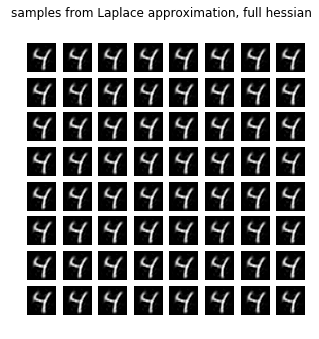

2550.0188
1071.6537
980.4719
968.22864
941.1387
760.45844
757.3877
741.61786
767.6763
788.5663
768.6877
747.7126
743.9709
760.5246
754.18256
741.35394
760.5341
749.6487
740.3836
742.80554


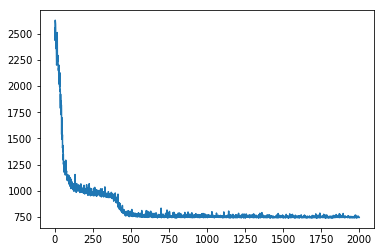

variance of VI [[-3.075445  -2.8460143 -3.053605  -3.1617608 -3.5042872 -2.582243
  -3.2028553 -3.6476161 -3.343648  -3.3109295]]


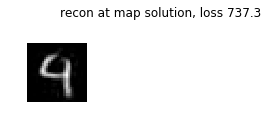

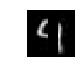

KeyboardInterrupt: ignored

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

#order minimia
varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)


for ii,ini_ in enumerate(map_minima_old[order]):
  
  # set MAP
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
 
  # Laplace approximation
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  #mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))

  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
    
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
    print('variance of VI', elbo_var)    


(1, 10, 10)


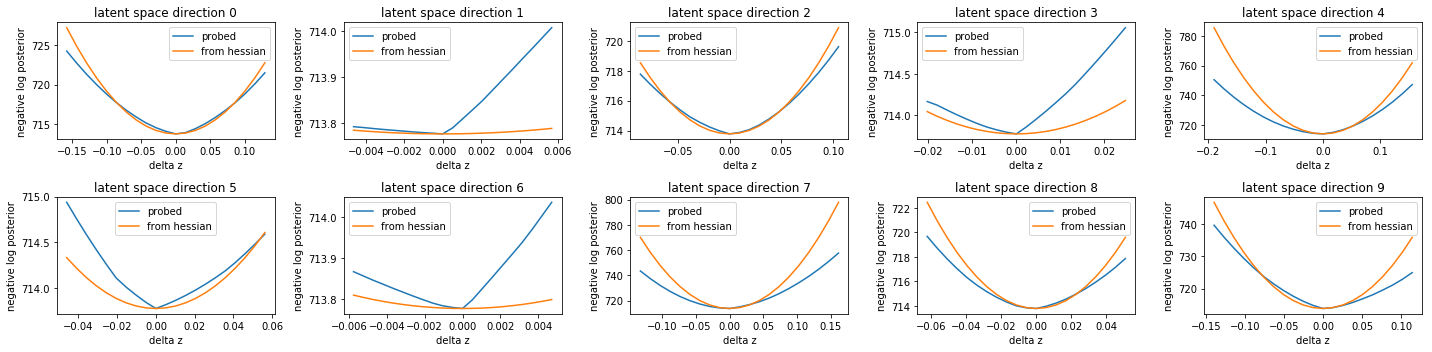

In [0]:
order     = np.argsort(l_minima_old)[0]
# testing Hessian
for ii,ini_ in enumerate([map_minima_old[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True, nvp_prior:False})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  print(GN_hessian.shape)
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from hessian')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


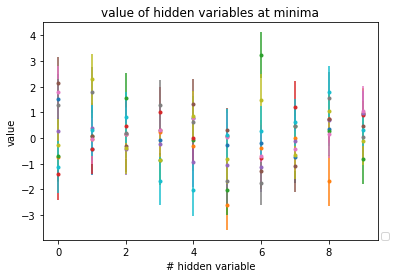

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**do vae on corrupted data with mean of posterior set to MAP values**

---

